In [40]:
# %load "../ml-mangrove/Segmentation/unet.py"
import segmentation_models as sm
import keras
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import rasterio
import subprocess
import tensorflow_datasets as tfds
import shutil
import pydensecrf.densecrf as dcrf
import cv2
import time
import imageio
from IPython.lib.display import Audio
from pydensecrf import utils
from gis_utils import raster
from rasterio.plot import show
from PIL import Image
from segmentation_models.utils import set_trainable
from glob import glob
from datetime import datetime
from PIL import Image
from tqdm import tqdm

In [41]:
#importing notebooks
#from ipynb.fs.full.<notebook_name> import *
from ipynb.fs.full.create_seg_dataset import create_seg_dataset
from ipynb.fs.full.gen_seg_labels import gen_seg_labels, tif_to_jpg, tile_raster
from ipynb.fs.full.raster_mask import raster_mask

In [42]:
# Resources: https://yann-leguilly.gitlab.io/post/2019-12-14-tensorflow-tfdata-segmentation/

'''
Documentation/Usage: This script is meant to be called with command line arguments.
--width (required): tile width
--input_rasters (required): space separated list of rasters (orthomosaics)
--input_vectors (required for training): space separated list of shapefiles (ordering should correspond with rasters)
--train: Flag. Add if training.
--test: Flag. Add if testing.
--weights (required): path to weights file, either to write to for training, or to use for testing (.h5)
--backbone (required): name of backbone to use, ex: resnet34, vgg16

For training it should be sufficient to just call the script using the list of rasters and vectors (and other required arguments), 
and currently you have to manually set the hyperparams in the code, but this should eventually be offloaded to a settings file or 
command line arguments. This will result in the training weights being saved in the specified .h5 file.

For testing you just need to call the script on the list of rasters and it will produce a mask of the entire
orthomosaic.
'''
#keras.backend.set_image_data_format('channels_first')
sm.set_framework('tf.keras')    # need this otherwise currently a bug in model.fit when used with tf.Datasets

# Globals
N_CHANNELS = 3
WIDTH = 256
HEIGHT = 256
LOSS_FUNC = sm.losses.DiceLoss()
NUM_CLASSES = 2

In [43]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its annotation.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    # Creating mask path from image path
    mask_path = tf.strings.regex_replace(img_path, "images", "annotations")
    mask_path = tf.strings.regex_replace(mask_path, "image", "annotation")
    mask = tf.io.read_file(mask_path)

    # The masks contain a class index for each pixels
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.uint8)
    
    #mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    # Note that we have to convert the new value (0)
    # With the same dtype than the tensor itself
    

    return {'image': image, 'segmentation_mask': mask}

In [44]:
@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images/masks between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its annotation.
    """
    input_mask = tf.cast(input_mask, tf.float32) / 255.0 # attempting to fix metrics
    input_mask = tf.round(input_mask)
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [45]:
@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its annotation.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the annotation also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
   
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))
    #input_mask = tf.image.rgb_to_grayscale(datapoint['segmentation_mask'])
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    #input_mask = tf.reshape(input_mask, (HEIGHT, WIDTH))  # removing single channel

    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [46]:
@tf.function
def load_image_val(datapoint: dict) -> tuple:
    """Normalize and resize a test image and its annotation.

    Notes
    -----
    Since this is for the val set, we don't need to apply
    any data augmentation technique.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))
    
    input_image, input_mask = normalize(input_image, input_mask)
    #input_mask = tf.reshape(input_mask, (HEIGHT, WIDTH)) # removing single channel

    
    return input_image, input_mask

In [47]:
@tf.function
def load_image(datapoint: dict) -> tuple:
    """Loads and image and resizes it

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT, WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT, WIDTH))
    #input_mask = tf.image.resize(datapoint['label'], (HEIGHT, WIDTH))

    return input_image, input_mask

In [48]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [49]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    #return pred_mask[0]
    return pred_mask

In [50]:
def show_predictions(model=None, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask[0])])

In [51]:
def evaluate(model, callback, raster_file, vector_file):
    #delete all files with extension
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    folderpath = "../dataset/training/"
    for file_name in os.listdir(folderpath + "images/images"):
        if file_name.endswith('.jpg'):
            os.remove(folderpath + "images/images/" + file_name)
    for file_name in os.listdir(folderpath + "images"):
        if file_name.endswith('.jpg'):
            os.remove(folderpath + "images/" + file_name)
    for file_name in os.listdir(folderpath + "images/labels"):
        if file_name.endswith('.jpg'):
            os.remove(folderpath + "images/labels/" + file_name)

#     shutil.rmtree(folderpath + "vectors/masks")
#     shutil.rmtree(folderpath + "vectors/nm")  #removing directories
#     shutil.rmtree(folderpath + "vectors/m")

    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
       try:
           for gpu in gpus:
               tf.config.experimental.set_memory_growth(gpu, True)
           logical_gpus = tf.config.experimental.list_logical_devices('GPU')
           print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
       except RuntimeError as e:
           print(e)
            
    print("Creating raster_masks...")
    raster_mask(raster_file, vector_file)
    temp_dir = os.path.dirname(vector_file)
    mask_file = os.path.join(temp_dir, "masks", "mask_binary.tif")

    # Generates segmentation labels
    out_dir = os.path.dirname(raster_file)
    gen_seg_labels(out_width, raster_file, vector_file, mask_file, out_dir, True, True)
    map_file = os.path.join(out_dir, "map.txt")
    #map_files.append(map_file)
        
    img_1, meta10 = raster.load_image("../dataset/training/vectors/masks/mask_binary.png")
    show(img_1)
    
    create_seg_dataset(map_file, "training", 0)
    
    test_dataset = tf.data.Dataset.list_files(training_data + "images/*.jpg", seed=SEED)
    test_dataset = test_dataset.map(load_image_val, num_parallel_calls=AUTOTUNE)
    test_dataset = test_dataset.batch(16)
    
    print("Evaluating on 2019-07_site03...")
    model.evaluate(test_dataset, 
                  callbacks=callback
                  )
    
    #print("Evaluating on 2019-07_site03...")

# raster_files = [img_p + "lap_2018-07_site1_120m_RGB_cc.tif", 
#                 img_p + "lap_2019-07_site03_120m_RGB_quick.tif",
#                 img_p + "lap_2018-07_site05_120m_RGB_cc.tif",
#                 img_p + "lap_2019-07_site06_120m_RGB_quick.tif",
#                 img_p + "lap_2018-07_site04_120m_RGB_cc.tif",
#                 img_p + "lap_2018-07_site06_120m_RGB_cc.tif",
#                 img_p + "psc_2018-05_site01_120m_RGB_cc.tif",
#                 img_p + "psc_2018-05_site11_120m_RGB.tif",
#                 img_p + "psc_2018-05_site12_120m_RGB.tif",
#                 img_p + "psc_2018-05_site8.tif",
#                 img_p + "psc_2018-07_site08_120m_RGB.tif",
#                 img_p + "psc_2018-07_site11_120m_RGB.tif",
#                 img_p + "psc_2018-07_site10_120m_RGB.tif",
#                 img_p + "psc_2018-07_site09_120m_RGB.tif",
#                 img_p + "psc_2018-05_site13-14_120m_RGB.tif",
#                ]

# vector_files = [vec_p + "lap_2018-07_site01_labels_m-nm.shp", 
#                 vec_p + "lap_2019-07_site03_labels_m-nm.shp", 
#                 vec_p + "lap_2018-07_site05_120m_m-nm_dissolve.shp",
#                 vec_p + "lap_2019-07_site06_120m_labels_m-nm.shp",
#                 vec_p + "lap_2018-07_site04_labels_m-nm.shp",
#                 vec_p + "lap_2018-07_site06_120m_RGB_m-nm.shp",
#                 vec_p + "psc_2018-05_site01_120m_RGB_cc labels_m-nm.shp",
#                 vec_p + "psc_2018-05_site11_120m_RGB_dissolved.shp",
#                 vec_p + "psc_2018-05_site12_labels_m-nm.shp",
#                 vec_p + "psc_2018-05_site8_labels_m-nm.shp",
#                 vec_p + "psc_2018-07_site08_120m_RGB_labels_m-nm.shp",
#                 vec_p + "psc_2018-07_site11_120m_RGB_m-nm.shp",
#                 vec_p + "psc_2018-07_site_10_labels_m-nm.shp",
#                 vec_p + "psc_201807_site9_mnm.shp",
#                 vec_p + "psc_2018_05_site1314_120m_mnm.shp",
#                ]

In [52]:
def densecrf(pred_mask, img, g_feats):
    img = np.reshape(img, (256, 256, 3))
    softmax = pred_mask.transpose((2, 0, 1))
    unary = utils.unary_from_softmax(softmax)
    
    # The inputs should be C-continious -- we are using Cython wrapper
    unary = np.ascontiguousarray(unary)
    
    d = dcrf.DenseCRF(img.shape[0] * img.shape[1], 2) # h * w, channels
    d.setUnaryEnergy(unary)
    
    #gaussian penalizes small pieces of segmentation that are spatially isolated
    d.addPairwiseEnergy(g_feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)
    
    # This creates the color-dependent features --
    # because the segmentation that we get from CNN are too coarse
    # and we can use local color features to refine them
    bi_feats = utils.create_pairwise_bilateral(sdims=(5, 5), schan=(20, 20, 20),
                                   img=img, chdim=2)

    d.addPairwiseEnergy(bi_feats, compat=10,
                     kernel=dcrf.DIAG_KERNEL,
                     normalization=dcrf.NORMALIZE_SYMMETRIC)
    
    Q = d.inference(1)
    res = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    return np.reshape(res, (256, 256, 1))

In [53]:
def IOU(array, val_array):
    assert array.shape == val_array.shape, "Array and Validation Array have different sizes."
    np.reshape(array, (HEIGHT, WIDTH))
    np.reshape(val_array, (HEIGHT, WIDTH))
    intersection = np.sum(array == val_array)
    union = array.shape[0] * array.shape[1]
    res = intersection / union
    assert res <= 1
    return res

In [54]:
# img, meta = raster.load_image("../dataset/testing/vectors/masks/mask_binary.tif")
# resampled, transform = raster.downsample_raster(img, 1/4)
# fig, ax = plt.subplots(figsize=(6,6))
# rasterio.plot.show(img, ax=ax)

In [70]:
def test(backbone, weight_file, raster_file):

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    print(f"Tensorflow ver. {tf.__version__}")

    # For reproducibility
    SEED = 42

    # Relevant directories/files
    image_dir = "../dataset/testing/images/images"
    annotation_dir = "../dataset/testing/annotations"
    label_dir = "../dataset/testing/images/labels"
    out_dir = "../dataset/testing/output"
    testing_data = "../dataset/testing/"
    model_weights = weight_file

    #Listing GPU info
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
       try:
           for gpu in gpus:
               tf.config.experimental.set_memory_growth(gpu, True)
           logical_gpus = tf.config.experimental.list_logical_devices('GPU')
           print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
       except RuntimeError as e:
           print(e)

    # Hyperparams
    BATCH_SIZE = 16
    BUFFER_SIZE = 1000 # See https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
    
    model = sm.Unet(
        #'vgg16', 
        backbone,
        input_shape=(HEIGHT, WIDTH, N_CHANNELS), 
        encoder_weights='imagenet', 
        weights=model_weights,
        encoder_freeze=True,    # only training decoder network
        classes=NUM_CLASSES, 
        activation='softmax'
        )

    # Might be unnecessary
    model.compile(
        'Adam', 
        #loss=sm.losses.bce_jaccard_loss, 
        loss=LOSS_FUNC,
        metrics=[sm.metrics.iou_score]
        )

    test_dataset = glob(image_dir + "/*.tif")
    DATASET_SIZE = len(test_dataset)
    tot_iou = 0 # for taking the mean iou of all the tiles at the end 
    
    # CRF Pairwise energies:
    # This potential penalizes small pieces of segmentation that are
    # spatially isolated -- enforces more spatially consistent segmentations
    g_feats = utils.create_pairwise_gaussian(sdims=(5, 5), shape=(HEIGHT, WIDTH))
    
    temp = os.path.basename(raster_file)
    raster_name = temp.replace(".tif", "") # isolate name of ortho w/out extension (.tif)

    
    # Loop for inference
    print("\nStarting inference... \n")
    for img_file in tqdm(test_dataset):
        #tif_file = img_file.replace("jpg", "tif") # 

        img = tf.io.read_file(img_file)
        img = tf.image.decode_jpeg
        img = np.asarray(Image.open(img_file)) / 255.0 # normalization not needed as we dont normalize the img for training
        img = img[:,:,:3] # slice off A channel
        img = img[np.newaxis, ...] # needs (batch_size, height, width, channels)
        pred_mask = model.predict(img)[0]
        pred_mask = densecrf(pred_mask, img, g_feats) # shape: (256, 256, 2)  -> (256, 256, 1)
        #pred_mask = create_mask(pred_mask) # shape: (256, 256, 2)  -> (256, 256, 1)
        pred_mask = 1 - pred_mask
        pred_mask = pred_mask * 255
        pred_mask = np.array(pred_mask).astype('uint8')  # should be binary (0, 255) values only 
        
        # get filepaths of true_mask and predicted mask for specific tile
        temp = os.path.basename(img_file)   # remove dir, -> "tif-name_00_00.tif"
        temp = temp.replace(raster_name, "") # code at end of raster -> "_00_00.tif"
        true_mask_fp =  label_dir + "/mask_binary" + temp # last bit is code: "_01_23.tif" for example 
        true_mask = np.asarray(Image.open(true_mask_fp))
        true_mask = true_mask[:,:,:1] # slice off 3 channels
        
        # compare predicted to ground truth "mask_binary" files
        tot_iou += IOU(pred_mask, true_mask)
        
        # Reading metadata from .tif
        with rasterio.open(img_file) as src: # changed "tif_file" -> "img_file"
            tif_meta = src.meta
            tif_meta['count'] = 1

        # Writing prediction mask as a .tif using extracted metadata
        mask_file = img_file.replace("images/images", "output") # changed "tif_file" -> "img_file"
        with rasterio.open(mask_file, "w", **tif_meta) as dest:
            # Rasterio needs [bands, width, height]
            pred_mask = np.rollaxis(pred_mask, axis=2)
            dest.write(pred_mask)
  
    print("Mean IOU:", tot_iou/DATASET_SIZE ) # display iou
    print("Merging tiles (to create mask ortho)...")
    call = "gdal_merge.py -o " + testing_data + "ortho_mask.tif " + " " + out_dir + "/*"
    print(call)
    subprocess.call(call, shell=True)
    
    return tot_iou/DATASET_SIZE

In [56]:
def train_setup(raster_files, vector_files, out_width):
    # Uses raster and vector file to create dataset for training
    data_files = zip(raster_files, vector_files)
    map_files = [] 

    for raster_file, vector_file in data_files:
        # Generates raster masks
        print("Creating raster_masks...")
        raster_mask(raster_file, vector_file)
        temp_dir = os.path.dirname(vector_file)
        mask_file = os.path.join(temp_dir, "masks", "mask_binary.tif")

        # Generates segmentation labels
        out_dir = os.path.dirname(raster_file)
        gen_seg_labels(out_width, raster_file, vector_file, mask_file, out_dir, True, True)
        map_file = os.path.join(out_dir, "map.txt")
        map_files.append(map_file)

    # Creating dataset to train UNet
    create_seg_dataset(map_files, "training", 0)

In [57]:
def test_setup(raster_files, out_width):
    out_dir = "../dataset/testing/output"
    test_dir = "../dataset/testing"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    print("\nTiling rasters...")
    for raster_file in raster_files:
        tile_raster(out_width, raster_file, test_dir, True, False)

In [58]:
def test_setup_iou(raster_file, vector_file, out_width):
    """ 
    Setup for displaying mean iou after testing, 
    expects directories to be present:
                                        'testing/images'       : with test rasters inside
                                        'testing/vectors'      : with test vectors inside
                                        'testing/images/images': for retiled rasters (.tif)
                                        'testing/vectors/masks': for retiled true_masks (.jpg)
                                        
    Will only work with ONE image at a time, also make sure to clear directories after use.
    """
    
    out_dir = "../dataset/testing/output"
    test_dir = "../dataset/testing"
    mask_file = test_dir + "/vectors/masks/mask_binary.tif"
    img_dir =  test_dir + "/images"
    
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    #for raster_file, vector_file in zip(raster_files, vector_files):
    print("Creating Mask(s)...") # creates 'mask_binary.tif;' in testing/vectors/masks 
    raster_mask(raster_file, vector_file)
        
        # creates labels and writes them to testing/images/labels
    gen_seg_labels(out_width, raster_file, vector_file, mask_file, img_dir, False, False)

In [59]:
def downsample(img, i):
    for x in range(i):
        rows, cols , _channels = map(int, img.shape)
        img = cv2.pyrDown(img, dstsize=(cols//2, rows//2))
    return img

def write_downsampled(img_path, i, out_path):
    if not os.path.exists(img_path):
        print(f"path {img_path} does not exist")
        return
    img = cv2.imread(img_path)
    img = downsample(img, i)
    cv2.imwrite(out_path, img)
    return
# print(img.shape)
# img = downsample(img, 5)
# print(img.shape)
# cv2.imwrite("downsampled.png", img)
# plt.imshow(img)

In [60]:
def play_tone():
    framerate = 4410
    play_time_seconds = 3

    t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
    audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
    Audio(audio_data, rate=framerate, autoplay=True)
    return

In [67]:
# initalize arguments
out_width = "256"
all_raster_files = [
#                 "lap_2018-07_site1_120m_RGB_cc.tif", 
                "lap_2019-07_site03_120m_RGB_quick.tif",
#                 "lap_2018-07_site05_120m_RGB_cc.tif",
#                 "lap_2019-07_site06_120m_RGB_quick.tif",
#                 "lap_2018-07_site04_120m_RGB_cc.tif",
#                 "lap_2018-07_site06_120m_RGB_cc.tif",
#                 "psc_2018-05_site01_120m_RGB_cc.tif",
#                 "psc_2018-05_site11_120m_RGB.tif",
#                 "psc_2018-05_site12_120m_RGB.tif",
#                 "psc_2018-05_site8.tif",
#                 "psc_2018-07_site08_120m_RGB.tif",
#                 "psc_2018-07_site11_120m_RGB.tif",
#                 "psc_2018-07_site10_120m_RGB.tif",
#                 "psc_2018-07_site09_120m_RGB.tif",
#                 "psc_2018-05_site13-14_120m_RGB.tif",
               ]

all_vector_files = [
#                 "lap_2018-07_site01_labels_m-nm.shp", 
                "lap_2019-07_site03_labels_m-nm.shp", 
#                 "lap_2018-07_site05_120m_m-nm_dissolve.shp",
#                 "lap_2019-07_site06_120m_labels_m-nm.shp",
#                 "lap_2018-07_site04_labels_m-nm.shp",
#                 "lap_2018-07_site06_120m_RGB_m-nm.shp",
#                 "psc_2018-05_site01_120m_RGB_cc labels_m-nm.shp",
#                 "psc_2018-05_site11_120m_RGB_dissolved.shp",
#                 "psc_2018-05_site12_labels_m-nm.shp",
#                 "psc_2018-05_site8_labels_m-nm.shp",
#                 "psc_2018-07_site08_120m_RGB_labels_m-nm.shp",
#                 "psc_2018-07_site11_120m_RGB_m-nm.shp",
#                 "psc_2018-07_site_10_labels_m-nm.shp",
#                 "psc_201807_site9_mnm.shp",
#                 "psc_2018_05_site1314_120m_mnm.shp",
               ]

weight_file = "../dataset/training/weights/08_10_vgg16_200_full_weight.h5"
backbone = "vgg16"

test_raster_files = ["../dataset/testing/images/" + img for img in all_raster_files]
test_vector_files = ["../dataset/testing/vectors/" + vec for vec in all_vector_files]

train_vector_files = ["../dataset/training/images/" + img for img in all_raster_files]
train_vector_files = ["../dataset/training/vectors/" + vec for vec in all_vector_files]

In [62]:
def clean_test_dir(test_dir, images=False, masks=False, output=False):
    """
    deletes file in test_dir based on args passed
    
    Parameters
    ----------
    test_dir: str
        path to test_dir (usually "../dataset/testing/")
    images: bool
        deletes all files in "test_dir/images/images", AND "test_dir/images/labels"
    masks: bool 
        deletes directories: "test_dir/m", "test_dir/nm", "test_dir/masks"
    output:
        deletes all files in "test_dir/output", AND "test_dir/ortho_mask.tif"
    
    Returns
    -------
    None
    """
    def handleError(func, path, exc_info): # for shutil.rmtree
        print(f"{path} caused error when deleting")
        pass
    
    if images:
        for file_name in os.listdir(test_dir + "images/images"):
            os.remove(test_dir + "images/images/" + file_name)
        for file_name in os.listdir(test_dir + "images/labels"):
            os.remove(test_dir + "images/labels/" + file_name)
    
    if masks:
        shutil.rmtree(test_dir + "vectors/masks", onerror=handleError) 
        shutil.rmtree(test_dir + "vectors/nm", onerror=handleError)  #removng directories
        shutil.rmtree(test_dir + "vectors/m", onerror=handleError)
        
    if output:
        for file_name in os.listdir(test_dir + "output"):
            os.remove(test_dir + "output/" + file_name)
        if os.path.exists(test_dir + "ortho_mask.tif"):
            os.remove(test_dir + "ortho_mask.tif")
        else:
            print("No ortho_mask to delete")    

In [63]:
def test_weights(test_raster_files, test_vector_files, full_weight_files, ds_factor, display=False):
    """
    Tests multiple weight_files on a set of images and their corresponding vectors.
    
    Creates a directory in "../dataset/testing/runs/MM-DD-YY_hr-min", where directories
    for each weight are created. Each weight directory has a text file with iou scores 
    for each image as well as downsampled images for each raster tested on.
    
    Parameters
    ----------
    raster_files: list[str]
        list of raster filepaths, MUST be in "../dataset/testing/", order should match vector_files (.tif)
    vector_files: list[str]
        list of vector filepaths, MUST be in "../dataset/testing/" (.shp)
    full_weight_files: list[str]
        list of weight filepaths (.h5)
    ds_factor: int
        how many times to recursively downsample img using cv2.pyrDown, each iteration halves size
    display: bool
        show output image after each prediction by each weight
    
    Returns
    -------
    None
    """
    def write_iou_scores(run_dir, weight_files, iou_scores):
        # save "iou.txt" to each "run_dir/weight/" and save "run_dir/all_iou_scores.txt"
        with open(run_dir + "all_iou_scores.txt", 'w') as f:
            for weight_list in iou_scores:
                for tup in weight_list:
                    if type(tup) != tuple:
                        f.write(tup + "\n")
                    else:
                        f.write(tup[0] + " iou: ")
                        f.write(str(tup[1]) + "\n")
                f.write("-------------\n")
        
        for i, weight in enumerate(weight_files):
            temp = os.path.basename(weight) # remove dir + extension
            bare_weight = temp.replace(".h5", "")   
            weight_dir = run_dir + bare_weight + "/"# dir for each weight 
            iou_scores[i].insert(0, "(test_image, iou_score) for weight:") # file header
            with open(weight_dir + 'iou_scores.txt', 'w') as f:
                for tup in iou_scores[i]:
                    if type(tup) != tuple:
                        f.write(tup + "\n")
                    else:
                        f.write(tup[0] + " iou: ")
                        f.write(str(tup[1]) + "\n")
                f.write("-------------\n")

    ############################################# setup
    print(f"There are {len(full_weight_files)} weight files")
    print(f"They will be tested on {len(test_raster_files)} images\n\n")
    test_dir = "../dataset/testing/"
    ortho_path = test_dir + "ortho_mask.tif"
    iou_scores = [[x] for x in full_weight_files] # list of iou scores where first entry is weight used
    testing_imgs = test_dir + "images/"
    run_dir =  test_dir + "runs/" + time.strftime('%m-%d-%y_%I-%M%p/') # dir with date_time
    if os.path.exists(run_dir):
        print(f"error: run_dir: {run_dir} already exists")
        return
    else:
        os.system("mkdir " + run_dir)
        
    for w in full_weight_files: # mk dir for each weight file to store downsampled imgs/iou.txt
        temp = os.path.basename(w) # remove dir + extension
        bare_weight = temp.replace(".h5", "") 
        if os.path.exists(run_dir + bare_weight):
            print(f"error: run_dir/weight: {run_dir + babre_weight} already exists")
        else: 
            os.system("mkdir " + run_dir + bare_weight)
            print("mkdir " + run_dir + bare_weight)
    
    if os.path.exists(ortho_path): # remove old output image
        os.remove("../dataset/testing/ortho_mask.tif")  
    ############################################# end setup
    
    for raster_file, vector_file in zip(test_raster_files, test_vector_files):
        test_setup_iou(raster_file, vector_file, out_width) # tile image and make true masks
        temp = os.path.basename(raster_file)
        raster_name = temp.replace(".tif", ".png") # remove directory and change to "img.png"
        
        for i, weight in enumerate(full_weight_files):
            temp = os.path.basename(weight) # remove dir + extension
            bare_weight = temp.replace(".h5", "")
            weight_dir = run_dir + bare_weight + "/"
            iou = test(backbone, weight, raster_file) # generate "../dataset/testing/ortho_mask.tif"
            
            write_downsampled(ortho_path, ds_factor, weight_dir + raster_name) #save ortho_mask to weight_dir
            assert iou_scores[i][0] == weight # check that appending correct list
            iou_scores[i].append((raster_file, iou)) # append raster_file, and iou to list
            
            if display: # show output mask
                img, meta = raster.load_image(ortho_path)
                resampled, transform = raster.downsample_raster(img, 1/4)
                fig, ax = plt.subplots(figsize=(6,6))
                rasterio.plot.show(resampled, ax=ax)
            clean_test_dir(test_dir, output=True) # remove output data that is unique to weight_file
        
        mask_path = run_dir + "binary_mask_" + raster_name
        write_downsampled(test_dir + "vectors/masks/mask_binary.tif", ds_factor, mask_path)
        clean_test_dir(test_dir, images=True, masks=True) # remove prior raster tiling data 
    # save an "iou.txt" file to each "run_dir/weight/" and save "run_dir/full_iou.txt" 
    write_iou_scores(run_dir, full_weight_files, iou_scores) 

Creating Mask(s)...
Splits exist, skipping splitting...
Reading shapefile...
Creating masks...
Saving masks...
Done.

Executing GDAL calls...
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/images ../dataset/testing/images/lap_2019-07_site03_120m_RGB_quick.tif
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/labels ../dataset/testing/vectors/masks/mask_binary.tif


  0%|          | 0/3782 [00:00<?, ?it/s]

Removing undersized tiles...


100%|██████████| 2985/2985 [00:00<00:00, 1814755.39it/s]

Number of Images: 2985
Number of Labels: 2985
Creating Map...
Done.
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs



  0%|          | 0/2985 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 2985/2985 [07:54<00:00,  6.29it/s]


Mean IOU: 0.9522969052619871
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*


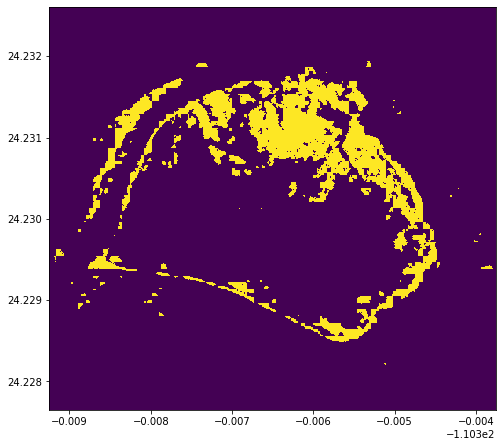

In [71]:
#Run Testing w/IOU metrics
if os.path.exists("../dataset/testing/ortho_mask.tif"): # remove old output image
    os.remove("../dataset/testing/ortho_mask.tif")
 
test_setup_iou(test_raster_files[0], test_vector_files[0], out_width) # tile image/mask
test(backbone, weight_file, test_raster_files[0]) # run test

# show test result  
img, meta = raster.load_image("../dataset/testing/ortho_mask.tif")
resampled, transform = raster.downsample_raster(img, 1/4)
fig, ax = plt.subplots(figsize=(8,8))
rasterio.plot.show(img, ax=ax)
play_tone()

There are 4 weight files
They will be tested on 6 images


mkdir ../dataset/testing/runs/08-24-20_10-35PM/unet_500_weights_vgg16
mkdir ../dataset/testing/runs/08-24-20_10-35PM/08_10_vgg16_200_full_weight
mkdir ../dataset/testing/runs/08-24-20_10-35PM/08_12_vgg16_350_full_weight-Copy1
mkdir ../dataset/testing/runs/08-24-20_10-35PM/08_12_vgg16_350_full_weight
Creating Mask(s)...
Splitting vectors...
Creating mangrove files in ../dataset/testing/vectors/m
Joined 1 mangrove polygons.
Creating nonmangrove files in ../dataset/testing/vectors/nm
Joined 1 nonmangrove polygons.
Reading shapefile...
Creating masks...
Saving masks...
Done.

Executing GDAL calls...
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/images ../dataset/testing/images/lap_2018-07_site06_120m_RGB_cc.tif
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/labels ../dataset/testing/vectors/masks/mask_binary.tif


  0%|          | 0/2652 [00:00<?, ?it/s]

Removing undersized tiles...


100%|██████████| 2024/2024 [00:00<00:00, 1663910.49it/s]

Number of Images: 2024
Number of Labels: 2024
Creating Map...
Done.
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs



  0%|          | 0/2024 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 2024/2024 [02:10<00:00, 15.54it/s]


Mean IOU: 0.8806715350848413
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/2024 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 2024/2024 [02:08<00:00, 15.70it/s]


Mean IOU: 0.789658256199049
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/2024 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 2024/2024 [02:09<00:00, 15.58it/s]


Mean IOU: 0.2398666336602373
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/2024 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 2024/2024 [02:09<00:00, 15.57it/s]


Mean IOU: 0.7753744464617944
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Creating Mask(s)...
Splitting vectors...
Creating mangrove files in ../dataset/testing/vectors/m
Joined 1 mangrove polygons.
Creating nonmangrove files in ../dataset/testing/vectors/nm
Joined 1 nonmangrove polygons.
Reading shapefile...
Creating masks...
Saving masks...
Done.

Executing GDAL calls...
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/images ../dataset/testing/images/psc_2018-05_site01_120m_RGB_cc.tif
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/labels ../dataset/testing/vectors/masks/mask_binary.tif


  0%|          | 0/2703 [00:00<?, ?it/s]

Removing undersized tiles...


100%|██████████| 2248/2248 [00:00<00:00, 1741879.81it/s]

Number of Images: 2248
Number of Labels: 2248
Creating Map...
Done.
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs



  0%|          | 0/2248 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 2248/2248 [02:25<00:00, 15.48it/s]


Mean IOU: 0.9456203094156611
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/2248 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 2248/2248 [02:22<00:00, 15.73it/s]


Mean IOU: 0.7941209446917225
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/2248 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 2248/2248 [02:24<00:00, 15.59it/s]


Mean IOU: 0.24647957065351492
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/2248 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 2248/2248 [02:24<00:00, 15.52it/s]


Mean IOU: 0.7709253250067769
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Creating Mask(s)...
Splitting vectors...
Creating mangrove files in ../dataset/testing/vectors/m
Joined 1 mangrove polygons.
Creating nonmangrove files in ../dataset/testing/vectors/nm
Joined 1 nonmangrove polygons.
Reading shapefile...
Creating masks...
Saving masks...
Done.

Executing GDAL calls...
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/images ../dataset/testing/images/psc_2018-05_site11_120m_RGB.tif
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/labels ../dataset/testing/vectors/masks/mask_binary.tif


  0%|          | 0/13950 [00:00<?, ?it/s]

Removing undersized tiles...


100%|██████████| 10998/10998 [00:00<00:00, 1644467.41it/s]

Number of Images: 10998
Number of Labels: 10998
Creating Map...
Done.
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs



  0%|          | 0/10998 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 10998/10998 [11:50<00:00, 15.48it/s]


Mean IOU: 0.8745698125866634
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/10998 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 10998/10998 [11:38<00:00, 15.75it/s]


Mean IOU: 0.7599555260269267
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/10998 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 10998/10998 [11:41<00:00, 15.68it/s]


Mean IOU: 0.5788917576189279
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/10998 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 10998/10998 [11:43<00:00, 15.62it/s]


Mean IOU: 0.6902673960295693
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Creating Mask(s)...
Splitting vectors...
Creating mangrove files in ../dataset/testing/vectors/m
Joined 1 mangrove polygons.
Creating nonmangrove files in ../dataset/testing/vectors/nm
Joined 1 nonmangrove polygons.
Reading shapefile...
Creating masks...
Saving masks...
Done.

Executing GDAL calls...
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/images ../dataset/testing/images/psc_2018-05_site12_120m_RGB.tif
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/labels ../dataset/testing/vectors/masks/mask_binary.tif


  0%|          | 0/7392 [00:00<?, ?it/s]

Removing undersized tiles...


100%|██████████| 3559/3559 [00:00<00:00, 1830700.02it/s]

Number of Images: 3559
Number of Labels: 3559
Creating Map...
Done.
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs



  0%|          | 0/3559 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 3559/3559 [03:50<00:00, 15.41it/s]


Mean IOU: 0.9328506911326808
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/3559 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 3559/3559 [03:52<00:00, 15.30it/s]


Mean IOU: 0.9702297038126273
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/3559 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 3559/3559 [03:54<00:00, 15.17it/s]


Mean IOU: 0.17028781583249553
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs


  0%|          | 0/3559 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 3559/3559 [03:50<00:00, 15.46it/s]


Mean IOU: 0.9593344139362795
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*
Creating Mask(s)...
Splitting vectors...
Creating mangrove files in ../dataset/testing/vectors/m
Joined 1 mangrove polygons.
Creating nonmangrove files in ../dataset/testing/vectors/nm
Joined 1 nonmangrove polygons.
Reading shapefile...
Creating masks...
Saving masks...
Done.

Executing GDAL calls...
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/images ../dataset/testing/images/psc_2018-05_site8.tif
gdal_retile.py -ps 256 256 -targetDir ../dataset/testing/images/labels ../dataset/testing/vectors/masks/mask_binary.tif


  0%|          | 0/18476 [00:00<?, ?it/s]

Removing undersized tiles...


100%|██████████| 11237/11237 [00:00<00:00, 1910861.30it/s]

Number of Images: 11237
Number of Labels: 11237
Creating Map...
Done.
Tensorflow ver. 2.2.0
4 Physical GPUs, 4 Logical GPUs



  0%|          | 0/11237 [00:00<?, ?it/s]


Starting inference... 



100%|██████████| 11237/11237 [12:00<00:00, 15.59it/s]


Mean IOU: 0.9100967248351567
Merging tiles (to create mask ortho)...
gdal_merge.py -o ../dataset/testing/ortho_mask.tif  ../dataset/testing/output/*


error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgcodecs/src/loadsave.cpp:74: error: (-215:Assertion failed) pixels <= (1<<30) in function 'validateInputImageSize'


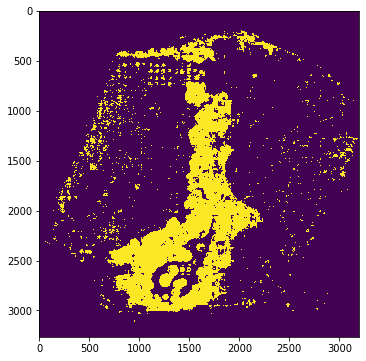

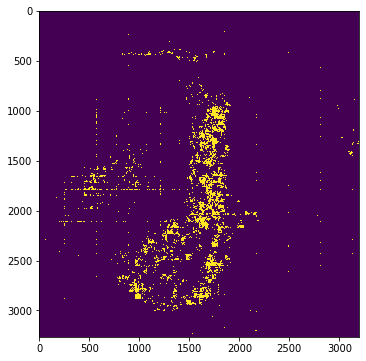

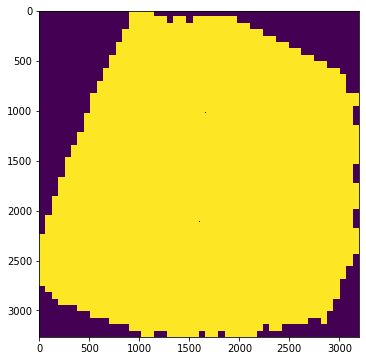

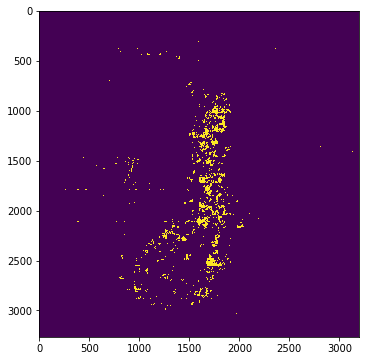

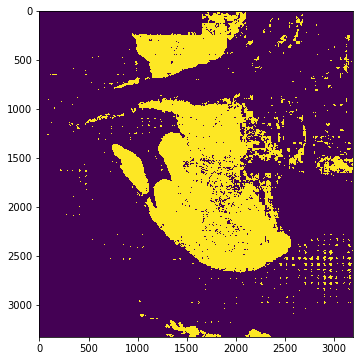

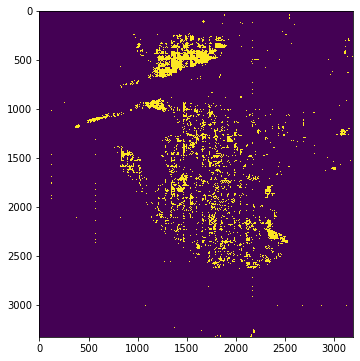

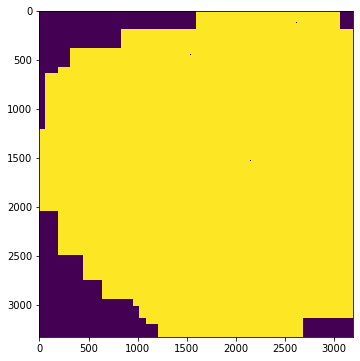

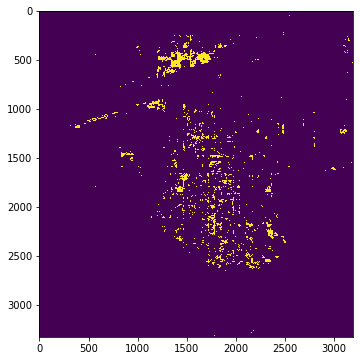

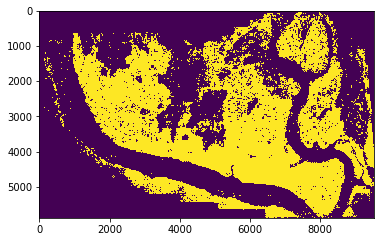

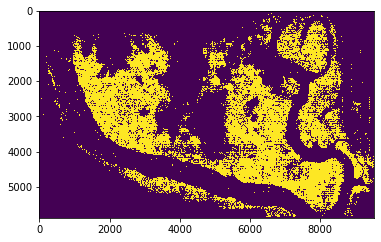

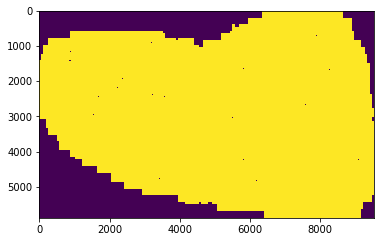

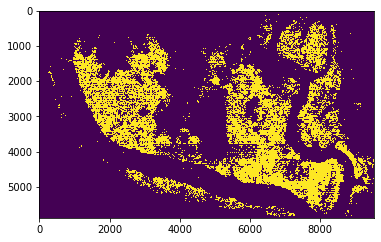

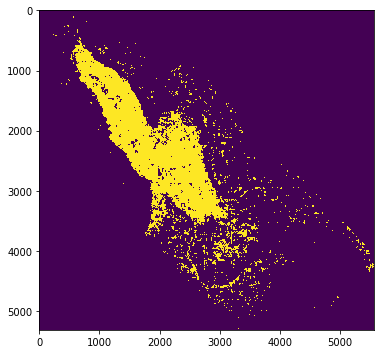

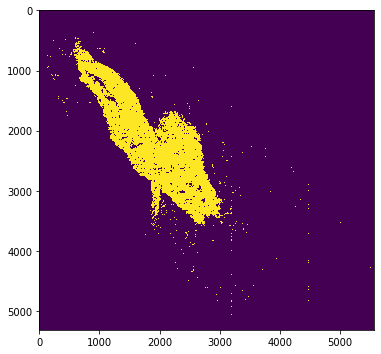

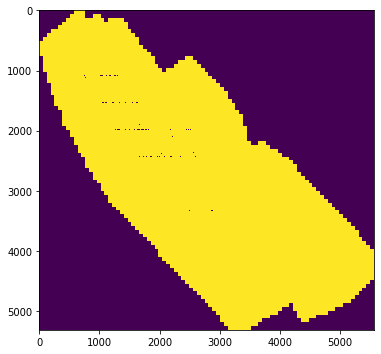

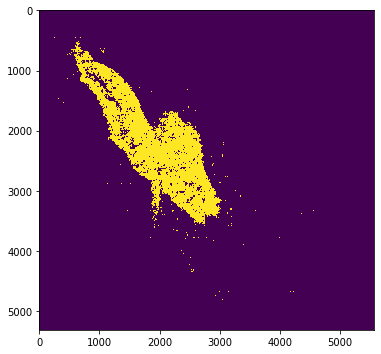

In [29]:
# Run testing for comparing weights
ds_factor = 5
w_dir = "../dataset/training/weights/"
full_weight_files = [
                w_dir + "unet_500_weights_vgg16.h5",
                w_dir + "08_10_vgg16_200_full_weight.h5",
                w_dir + "08_12_vgg16_350_full_weight-Copy1.h5", # weights copy when stopped at 220 epochs
                w_dir + "08_12_vgg16_350_full_weight.h5", # restarted twice and finished at 350 epochs
                ]

test_weights(test_raster_files, test_vector_files, full_weight_files, ds_factor, display=True)

In [140]:
#Run Training
#train_setup(raster_files, vector_files, out_width)
train(backbone, weight_file)

Tensorflow ver. 2.2.0
1 Physical GPUs, 1 Logical GPUs
The Training Dataset contains 2985 images.
187/187 [==============================] - 30s 161ms/step - loss: 0.6777 - iou_score: 0.2503


In [ ]:
# if __name__ == "__main__":
#     TRAIN = False
#     TEST = False

#     parser = argparse.ArgumentParser(description="UNet Training and Inference Script (Note: order of rasters and vectors must correspond to one another)")
#     parser.add_argument("--width",help = "Width of output tiles")
#     parser.add_argument("--input_rasters", nargs='*', help = "space separated input orthomosaic (.tif)")
#     parser.add_argument("--input_vectors", nargs='*', help = "space separated input labels (.shp)")
#     parser.add_argument("--train", action='store_true', help = "training UNet")
#     parser.add_argument("--test", action='store_true', help = "testing UNet")
#     parser.add_argument("--weights", help = "path to weight file, either to save or use (.h5)")
#     parser.add_argument("--backbone", help = "segmentation model backbone, ex: resnet34, vgg16, etc.")
#     args = parser.parse_args()

#     # Parsing arguments
#     if args.width:
#         out_width = args.width
#     else:
#         print("Need to specify width, exiting.")
#         exit()
#     if args.input_rasters:
#         raster_files = args.input_rasters
#     else:
#         # Always needs a raster
#         print("Need to specify raster file, exiting.")
#         exit()
#     if args.input_vectors:
#         vector_files = args.input_vectors
#     else:
#         # Requires vector labes for training, not inference
#         if args.train:
#             print("Need to specify input vector, exiting.")
#             exit()
#     if args.train and args.test:
#         print("Can't train and test at the same time... exiting.")
#         exit()
#     elif args.train:
#         TRAIN = True
#     elif args.test:
#         TEST = True
#     if args.weights:
#         weight_file = args.weights
#     else:
#         print("Need weight file, exiting.")
#         exit()
#     if args.backbone:
#         backbone = args.backbone
#     else:
#         print("Need to specify backbone, exiting.")
#         exit()

#     # Selecting mode
#     if TRAIN: 
#         train_setup(raster_files, vector_files, out_width)
#         train(backbone, weight_file)
#     if TEST:
#         test_setup(raster_files, out_width)
#         test(backbone, weight_file)
#         #test_optimized(backbone, weight_file)

In [155]:
#delete all training/images, /images/images, /images/labels, images/masks, 
#images/m, images/nm, anotations

#delete all files with extension
folderpath = "../dataset/training/"
for file_name in os.listdir(folderpath + "images/images"):
    if file_name.endswith('.jpg'):
        os.remove(folderpath + "images/images/" + file_name)
for file_name in os.listdir(folderpath + "images"):
    if file_name.endswith('.jpg'):
        os.remove(folderpath + "images/" + file_name)
for file_name in os.listdir(folderpath + "images/labels"):
    if file_name.endswith('.jpg'):
        os.remove(folderpath + "images/labels/" + file_name)

shutil.rmtree(folderpath + "vectors/masks")
shutil.rmtree(folderpath + "vectors/nm")  #removng directories
shutil.rmtree(folderpath + "vectors/m")
shutil.rmtree("../dataset/testing/output")
shutil.rmtree("../dataset/testing/images")

In [64]:
#delete testing masks/images
clean_test_dir("../dataset/testing/", images=True, masks=True, output=True)

No ortho_mask to delete
